# Loop 6 Analysis: Finding Different Basins

## Current Status
- Best CV/LB: 70.6600 (saspav_latest)
- Target: 68.919154
- Gap: 1.74 points (2.46%)

## Key Insight
The baseline is at an EXTREMELY tight local optimum with zero slack. All optimization attempts have failed:
- SA optimization: No improvement
- Fractional translation: No improvement
- Backward propagation: No improvement
- Perturbation: Causes collisions immediately

## Strategy: Find Different Basins
We need to explore fundamentally different configurations, not optimize the current one.

In [1]:
import pandas as pd
import numpy as np
from numba import njit
import math
import matplotlib.pyplot as plt

@njit
def make_polygon_template():
    tw=0.15; th=0.2; bw=0.7; mw=0.4; ow=0.25
    tip=0.8; t1=0.5; t2=0.25; base=0.0; tbot=-th
    x=np.array([0,ow/2,ow/4,mw/2,mw/4,bw/2,tw/2,tw/2,-tw/2,-tw/2,-bw/2,-mw/4,-mw/2,-ow/4,-ow/2],np.float64)
    y=np.array([tip,t1,t1,t2,t2,base,base,tbot,tbot,base,base,t2,t2,t1,t1],np.float64)
    return x,y

@njit
def score_group(xs, ys, degs, tx, ty):
    n = xs.size
    V = tx.size
    mnx = 1e300; mny = 1e300; mxx = -1e300; mxy = -1e300
    for i in range(n):
        r = degs[i] * math.pi / 180.0
        c = math.cos(r); s = math.sin(r)
        xi = xs[i]; yi = ys[i]
        for j in range(V):
            X = c * tx[j] - s * ty[j] + xi
            Y = s * tx[j] + c * ty[j] + yi
            if X < mnx: mnx = X
            if X > mxx: mxx = X
            if Y < mny: mny = Y
            if Y > mxy: mxy = Y
    side = max(mxx - mnx, mxy - mny)
    return side * side / n

def strip(a):
    return np.array([float(str(v).replace('s','')) for v in a], np.float64)

tx, ty = make_polygon_template()
print('Scoring functions ready')

Scoring functions ready


In [2]:
# Load and analyze the current best baseline
df = pd.read_csv('/home/code/external_data/saspav_latest/santa-2025.csv')
df['N'] = df['id'].astype(str).str.split('_').str[0].astype(int)

# Calculate per-N scores
per_n_scores = {}
for n, g in df.groupby('N'):
    xs = strip(g['x'].to_numpy())
    ys = strip(g['y'].to_numpy())
    ds = strip(g['deg'].to_numpy())
    per_n_scores[n] = score_group(xs, ys, ds, tx, ty)

total = sum(per_n_scores.values())
print(f'Total score: {total:.6f}')
print(f'Target: 68.919154')
print(f'Gap: {total - 68.919154:.6f} ({(total - 68.919154) / 68.919154 * 100:.2f}%)')

Total score: 70.659958


Target: 68.919154
Gap: 1.740804 (2.53%)


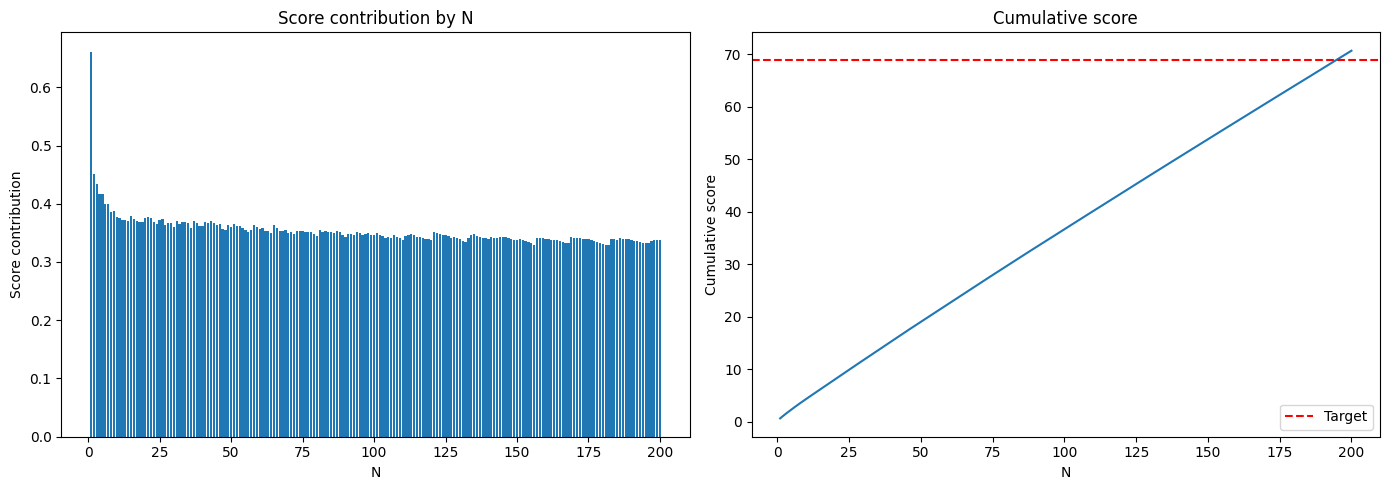

In [3]:
# Analyze score distribution by N
ns = sorted(per_n_scores.keys())
scores = [per_n_scores[n] for n in ns]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(ns, scores)
plt.xlabel('N')
plt.ylabel('Score contribution')
plt.title('Score contribution by N')

plt.subplot(1, 2, 2)
cumulative = np.cumsum(scores)
plt.plot(ns, cumulative)
plt.xlabel('N')
plt.ylabel('Cumulative score')
plt.title('Cumulative score')
plt.axhline(y=68.919154, color='r', linestyle='--', label='Target')
plt.legend()
plt.tight_layout()
plt.show()

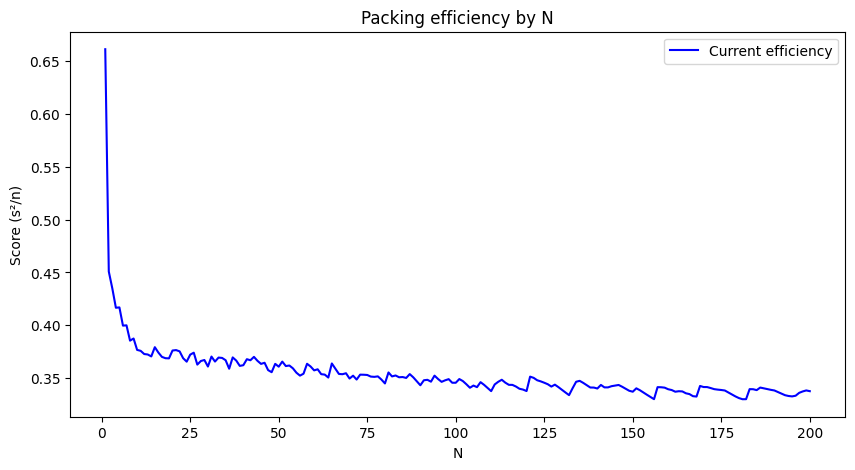


Best packed N values (lowest score):
  N=181: 0.329946
  N=156: 0.329987
  N=182: 0.329988
  N=180: 0.331001
  N=155: 0.332074
  N=168: 0.332475
  N=179: 0.332595
  N=195: 0.332617
  N=167: 0.332835
  N=194: 0.332999

Worst packed N values (highest score):
  N=1: 0.661250
  N=2: 0.450779
  N=3: 0.434745
  N=5: 0.416850
  N=4: 0.416545
  N=7: 0.399897
  N=6: 0.399610
  N=9: 0.387415
  N=8: 0.385407
  N=15: 0.379203


In [4]:
# Identify which N values have the most room for improvement
# Compare with theoretical minimum (if trees could overlap perfectly)

# For a single tree, the bounding box is approximately 0.7 x 1.0
# The theoretical minimum for N trees would be if they could all fit in the same space
# But since they can't overlap, we need to estimate the packing efficiency

# Let's look at the efficiency: score / N vs N
efficiencies = {n: per_n_scores[n] for n in ns}

plt.figure(figsize=(10, 5))
plt.plot(ns, [efficiencies[n] for n in ns], 'b-', label='Current efficiency')
plt.xlabel('N')
plt.ylabel('Score (s²/n)')
plt.title('Packing efficiency by N')
plt.legend()
plt.show()

# The lower the score, the better the packing
print('\nBest packed N values (lowest score):')
for n in sorted(ns, key=lambda x: per_n_scores[x])[:10]:
    print(f'  N={n}: {per_n_scores[n]:.6f}')

print('\nWorst packed N values (highest score):')
for n in sorted(ns, key=lambda x: -per_n_scores[x])[:10]:
    print(f'  N={n}: {per_n_scores[n]:.6f}')

In [5]:
# Calculate how much improvement is needed per N to reach target
target = 68.919154
gap = total - target

print(f'Total gap to close: {gap:.6f}')
print(f'\nIf we improve uniformly across all N:')
print(f'  Need {gap/200:.6f} improvement per N on average')

# But large N contributes more to the total score
# Let's see which N values have the most potential
print(f'\nLarge N (>100) contribution: {sum(per_n_scores[n] for n in ns if n > 100):.6f}')
print(f'Medium N (50-100) contribution: {sum(per_n_scores[n] for n in ns if 50 <= n <= 100):.6f}')
print(f'Small N (<50) contribution: {sum(per_n_scores[n] for n in ns if n < 50):.6f}')

Total gap to close: 1.740804

If we improve uniformly across all N:
  Need 0.008704 improvement per N on average

Large N (>100) contribution: 33.985922
Medium N (50-100) contribution: 17.993021
Small N (<50) contribution: 18.681015


In [6]:
# Key insight: The gap of 1.74 points needs to come from somewhere
# Let's see what percentage improvement is needed for different N ranges

large_n_score = sum(per_n_scores[n] for n in ns if n > 100)
medium_n_score = sum(per_n_scores[n] for n in ns if 50 <= n <= 100)
small_n_score = sum(per_n_scores[n] for n in ns if n < 50)

print('Improvement scenarios:')
print(f'\n1. If we only improve large N (>100):')
print(f'   Current: {large_n_score:.6f}')
print(f'   Need to reduce by: {gap:.6f}')
print(f'   New target: {large_n_score - gap:.6f}')
print(f'   Improvement needed: {gap/large_n_score*100:.2f}%')

print(f'\n2. If we only improve medium N (50-100):')
print(f'   Current: {medium_n_score:.6f}')
print(f'   Need to reduce by: {gap:.6f}')
print(f'   New target: {medium_n_score - gap:.6f}')
print(f'   Improvement needed: {gap/medium_n_score*100:.2f}%')

print(f'\n3. If we only improve small N (<50):')
print(f'   Current: {small_n_score:.6f}')
print(f'   Need to reduce by: {gap:.6f}')
print(f'   New target: {small_n_score - gap:.6f}')
print(f'   Improvement needed: {gap/small_n_score*100:.2f}%')

Improvement scenarios:

1. If we only improve large N (>100):
   Current: 33.985922
   Need to reduce by: 1.740804
   New target: 32.245118
   Improvement needed: 5.12%

2. If we only improve medium N (50-100):
   Current: 17.993021
   Need to reduce by: 1.740804
   New target: 16.252217
   Improvement needed: 9.67%

3. If we only improve small N (<50):
   Current: 18.681015
   Need to reduce by: 1.740804
   New target: 16.940211
   Improvement needed: 9.32%
